Colab Preperation for Run

In [ ]:
!git clone  https://github.com/noabendavid/Deep_Learning_Final_Project.git
%cd Deep_Learning_Final_Project
!ls


fatal: destination path 'Deep_Learning_Final_Project' already exists and is not an empty directory.
/content/Deep_Learning_Final_Project
data		     outputs	  requirements.txt  vit.py
main_notebook.ipynb  __pycache__  sam.py


In [ ]:
!pip install -r requirements.txt

In [ ]:
!rm -rf "/content/Deep_Learning_Final_Project/outputs"

In [ ]:
#mount driver for backups
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
drive_dir = f"/content/drive/MyDrive/project_backup"
os.makedirs(drive_dir, exist_ok=True)

## 1) Setup and Imports


In [ ]:

import os, copy, random, sys, shutil
import importlib.util
from dataclasses import dataclass, asdict
from pathlib import Path
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR, OneCycleLR
from torchvision import datasets, transforms, models
from torchvision.transforms import RandAugment
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,auc, precision_recall_curve, average_precision_score, f1_score)
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tabulate

from PIL import Image, ImageOps
from sam import SAM

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True
torch.backends.cuda.enable_flash_sdp(True)
torch.backends.cuda.enable_mem_efficient_sdp(True)
torch.backends.cuda.enable_math_sdp(True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cuda


## 2) Import VIT implementation `vit.py`


In [ ]:

VIT_PY_PATH = 'vit.py'
assert os.path.exists(VIT_PY_PATH), f'Could not find {VIT_PY_PATH}'
spec = importlib.util.spec_from_file_location("my_vit", VIT_PY_PATH)
vit = importlib.util.module_from_spec(spec)
sys.modules["my_vit"] = vit
spec.loader.exec_module(vit)

print("Found in vit.py ->",
      "ViTClassifier:", hasattr(vit, 'ViTClassifier'),
      "| build_transformer:", hasattr(vit, 'build_transformer'))

Found in vit.py -> ViTClassifier: True | build_transformer: True


In [ ]:
# Sanity check
B, C, H, W = 2, 1, 224, 224
x = torch.randn(B, C, H, W)

vit_build = vit.build_transformer(x, patch_size=16, d_model=384, Nx=8, h=6, d_ff=1536)
y = vit_build(x)
assert y.shape == (B, 1 + (H//16)*(W//16), 384)

head = vit.ViTClassifier(x, num_classes=2, d_model=384)

logits = head(x)
assert logits.shape == (B, 2)
print("OK!")
del vit_build, head, logits

OK!



## 3) Configuration


In [ ]:
@dataclass
class Config:
    # paths
    data_dir = './data/chest_xray'
    output_dir = './outputs'

    # data / transforms
    img_size = 224

    # optimization
    epochs = 20
    lr = 1e-4
    weight_decay = 0.05

    # SAM
    use_sam = False
    sam_rho = 0.05
    sam_adaptive = True

    # model vit
    patch_size = 16
    d_model = 768
    num_classes = 2

    #ResNet
    batch_size = 32
    pretrained = True
    dropout = 0.4
    freeze_until = "layer3"

    # dataloader
    num_workers = 2
    pin_memory = False

    scheduler = "cosine_warmup"
    warmup_epochs = 3
    min_lr = 1e-6

    # training utils
    use_amp = True
    clip_grad = 1.0


cfg = Config()
print(cfg)


Config()



## 4) Utility functions

In [ ]:
def class_counts(path):
    data_splits = ['train', 'val', 'test']
    # Class counts per split
    counts = []
    for split in data_splits:
        split_path = data_root / split
        if not split_path.exists():
            raise FileNotFoundError(f"Missing split folder: {split_path}")
        ds = datasets.ImageFolder(split_path)
        class_names = ds.classes
        c = Counter([label for _, label in ds.samples])
        for cls_idx, cls_name in enumerate(class_names):
            counts.append({'split': split, 'class': cls_name, 'count': c.get(cls_idx, 0)})
    return pd.DataFrame(counts)

def backup_outputs(repo_dir="/content/Deep_Learning_Final_Project", outputs_dir="outputs", drive_dir=drive_dir):
    src = os.path.join(repo_dir, outputs_dir)
    dst = os.path.join(drive_dir, outputs_dir)

    # If already exists in Drive, remove to avoid merging old files
    if os.path.exists(dst):
        shutil.rmtree(dst)

    shutil.copytree(src, dst)
    print(f"Copied {src} → {dst}")

def erase_file(path, file_name):
  file_path = Path(f"{path}/{file_name}")
  file_path.exists()

  if file_path.exists():
      file_path.unlink()
      print("Fil deleted successfully.")
  else:
      print("File not found.")


## 5) Dataset & EDA


,split,class,count
0,train,NORMAL,1341
1,train,PNEUMONIA,3875
2,val,NORMAL,8
3,val,PNEUMONIA,8
4,test,NORMAL,234
5,test,PNEUMONIA,390


Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs


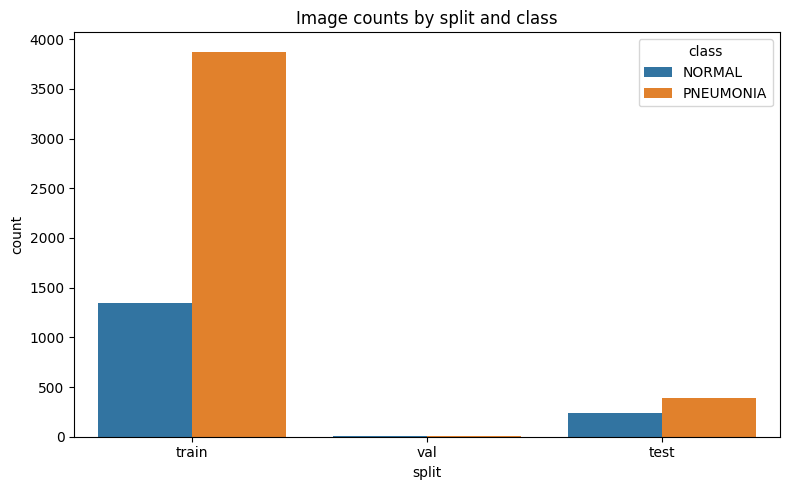

In [ ]:
data_root = Path(cfg.data_dir)
assert data_root.exists(), f"Dataset root not found: {data_root}"

os.makedirs(os.path.join(cfg.output_dir,'figures'), exist_ok=True)
os.makedirs(os.path.join(cfg.output_dir,'results'), exist_ok=True)
os.makedirs(os.path.join(cfg.output_dir,'models'), exist_ok=True)

counts_df = class_counts(data_root)
counts_df.to_csv(f'{cfg.output_dir}/results/class_counts_by_split.csv', index=False)
print(counts_df)

plt.figure(figsize=(8,5))
sns.barplot(data=counts_df, x='split', y='count', hue='class')
plt.title('Image counts by split and class')
plt.tight_layout()
plt.savefig(os.path.join(cfg.output_dir,'figures', 'class_counts_by_split.png'), dpi=200)
backup_outputs()
plt.show()
plt.close()



### Adjust train/val

The current val set is far too small for reliable early stopping, tuning, and sanity checks the variance will be huge. We will adjust validation of ~15% of the training pool.

In [ ]:
# 1. Load the current training and validation folder leave test untouched
train_dir = f"{cfg.data_dir}/train"
val_dir = f"{cfg.data_dir}/val"
test_dir = f"{cfg.data_dir}/test"

train_raw = datasets.ImageFolder(train_dir)
val_raw = datasets.ImageFolder(val_dir)

# ensure same class mapping
assert train_raw.class_to_idx == val_raw.class_to_idx, "train/val class_to_idx mismatch"

# combined (path, label) list
combined_samples = train_raw.samples + val_raw.samples
combined_paths   = [path for path, _ in combined_samples]
combined_labels  = [label for _, label in combined_samples]

# 2. Stratified re-split into new train/val
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=SEED)
new_train_idx, new_val_idx = next(sss.split(range(len(combined_labels)), combined_labels))

new_train_paths = [combined_paths[i] for i in new_train_idx]
new_train_labels= [combined_labels[i] for i in new_train_idx]
new_val_paths   = [combined_paths[i] for i in new_val_idx]
new_val_labels  = [combined_labels[i] for i in new_val_idx]

# 3. New split distribution
train_counts = Counter(new_train_labels)
val_counts   = Counter(new_val_labels)

# Map back to class names
idx_to_class = {v: k for k, v in train_raw.class_to_idx.items()}

total_train = sum(train_counts.values())
total_val   = sum(val_counts.values())

print("\nNew TRAIN percentages:")
for cls_idx, count in train_counts.items():
    print(f"  {idx_to_class[cls_idx]}: {count} ({count/total_train:.2%})")

print("\nNew VAL percentages:")
for cls_idx, count in val_counts.items():
    print(f"  {idx_to_class[cls_idx]}: {count} ({count/total_val:.2%})")




New TRAIN percentages:
  NORMAL: 1147 (25.79%)
  PNEUMONIA: 3300 (74.21%)

New VAL percentages:
  NORMAL: 202 (25.73%)
  PNEUMONIA: 583 (74.27%)


In [ ]:
# Compute mean/std for 40% samples from the new train files

# 1. Random sample files
rng = random.Random(SEED)

# Group by class
by_cls = {}
for p, y in zip(new_train_paths, new_train_labels):
    by_cls.setdefault(y, []).append(p)

# Sample 40% from each class
sampled_files = []
for y, file_list in by_cls.items():
    n_to_sample = max(1, int(len(file_list) * 0.4))
    sampled_files.extend(rng.sample(file_list, n_to_sample))

sizes = []
total_pixels = 0
sum_pixels = 0.0
sumsq_pixels = 0.0

for p in tqdm(sampled_files, desc="Scanning images for EDA"):
    # Ensure file path is str/Path
    p = Path(p)
    # Always close images using context manager
    with Image.open(p) as img:
        sizes.append(img.size)
        g = ImageOps.grayscale(img)
        arr = np.asarray(g, dtype=np.float32)

    n = arr.size
    total_pixels += n
    sum_pixels += float(arr.sum())
    sumsq_pixels += float((arr * arr).sum())

    # help GC on large loops
    del arr
    if total_pixels % (256*1024*1024) == 0:
        gc.collect()

# Compute mean & std
mean = sum_pixels / total_pixels
var = max(0.0, (sumsq_pixels / total_pixels) - (mean ** 2))
std = float(np.sqrt(var))

# Save sizes
sizes_df = pd.DataFrame(sizes, columns=['width', 'height'])
out_csv = Path(cfg.output_dir) / "results" / "image_sizes_sample.csv"
out_csv.parent.mkdir(parents=True, exist_ok=True)
sizes_df.to_csv(out_csv, index=False)
backup_outputs()




Scanning images for EDA: 100%|██████████| 1778/1778 [00:15<00:00, 113.44it/s]

Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs


In [ ]:
# 2. Compute mean and std
def compute_mean_std_from_sampled_files(files_path, crops_per_image = 4, resize_short = 256, crop_size = cfg.img_size) :
    channel_sum = None
    channel_sqsum = None
    count = 0

    for f in files_path:
        try:
            img = Image.open(f)
        except Exception:
            continue

        # Convert mode if needed
        if img.mode != 'RGB': img = img.convert('RGB')

        # Resize shortest side
        w, h = img.size
        scale = resize_short / float(min(w, h))
        new_w, new_h = max(1, int(w*scale)), max(1, int(h*scale))
        img_resized = img.resize((new_w, new_h), Image.BILINEAR)

        # Random crops
        for _ in range(crops_per_image):
            if new_w < crop_size or new_h < crop_size:
                left = max((new_w - crop_size)//2, 0)
                top  = max((new_h - crop_size)//2, 0)
            else:
                left = rng.randint(0, new_w - crop_size)
                top  = rng.randint(0, new_h - crop_size)
            crop = img_resized.crop((left, top, left+crop_size, top+crop_size))

            # Convert to tensor
            arr = np.asarray(crop, dtype=np.float32) / 255.0
            if arr.ndim == 2:
                arr = np.repeat(arr[..., None], 3, axis=2)
            arr = np.transpose(arr, (2,0,1))

            t = torch.from_numpy(arr)
            C = t.shape[0]
            if channel_sum is None:
                channel_sum = torch.zeros(C, dtype=torch.float64)
                channel_sqsum = torch.zeros(C, dtype=torch.float64)

            flat = t.view(C, -1)
            channel_sum += flat.mean(dim=1).double()
            channel_sqsum += (flat**2).mean(dim=1).double()
            count += 1

    mean = (channel_sum / max(count,1)).float()
    var  = (channel_sqsum / max(count,1) - mean.double().pow(2)).float()
    std  = torch.sqrt(torch.clamp(var, min=1e-8))
    return mean, std

train_mean, train_std = compute_mean_std_from_sampled_files(sampled_files)

print("\nSampled training images:")
print("Mean:", train_mean.tolist())
print("Std:", train_std.tolist())


Sampled training images:
Mean: [0.5600165724754333, 0.5600165724754333, 0.5600165724754333]
Std: [0.189881831407547, 0.189881831407547, 0.189881831407547]


## 6) Data Transforms & Dataloaders

In [ ]:
# 1. Build transform using train stats
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(cfg.img_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(train_mean.tolist(), train_std.tolist()),
])

val_tf = transforms.Compose([
    transforms.Resize(int(cfg.img_size*1.1)),
    transforms.CenterCrop(cfg.img_size),
    transforms.ToTensor(),
    transforms.Normalize(train_mean.tolist(), train_std.tolist()),
])

# 2. Wrap new test and validation split into datasets that read from file path
class PathsImageFolderLike(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        p, y = self.paths[i], self.labels[i]
        img = Image.open(p)
        if img.mode != 'RGB': img = img.convert('RGB')
        if self.transform: img = self.transform(img)
        return img, y

train_ds = PathsImageFolderLike(new_train_paths, new_train_labels, transform=train_tf)
val_ds = PathsImageFolderLike(new_val_paths, new_val_labels, transform=val_tf)

# 3. Test is untouched
test_ds = datasets.ImageFolder(test_dir, transform=val_tf)

# 4. Dataloaders
train_loader = DataLoader(train_ds, batch_size = cfg.batch_size, shuffle=True,  num_workers = cfg.num_workers, pin_memory=cfg.pin_memory)
val_loader = DataLoader(val_ds, batch_size = cfg.batch_size, shuffle=False, num_workers = cfg.num_workers, pin_memory=cfg.pin_memory)
test_loader = DataLoader(test_ds, batch_size = cfg.batch_size, shuffle=False, num_workers = cfg.num_workers, pin_memory=cfg.pin_memory)

len(train_ds), len(val_ds) if val_ds else None, len(test_ds)

(4447, 785, 624)

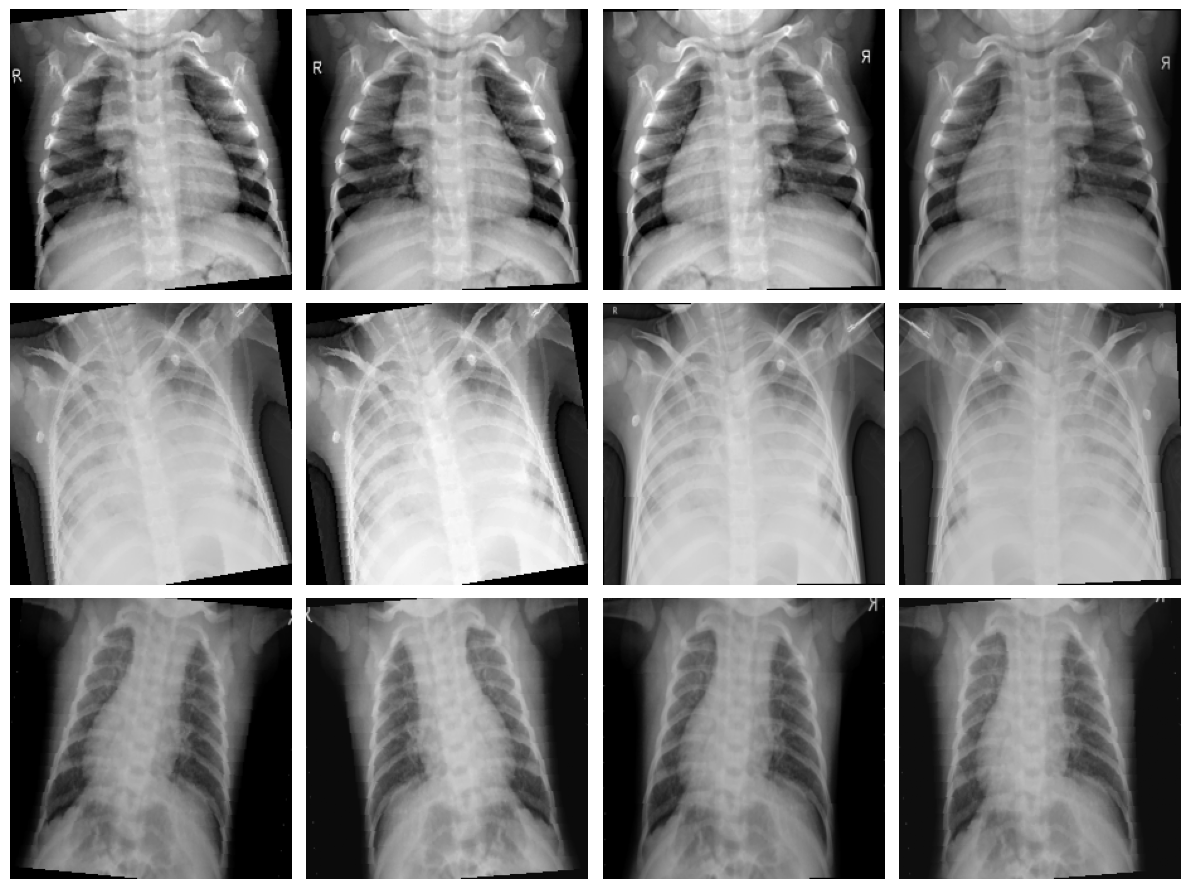

In [ ]:
# Preview augmentations
preview_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

sample_paths = random.sample(new_train_paths, 3)
n_augments = 4

fig, axes = plt.subplots(len(sample_paths), n_augments, figsize=(n_augments*3, len(sample_paths)*3))

for i, path in enumerate(sample_paths):
    img = Image.open(path).convert('RGB')
    for j in range(n_augments):
        aug_img = preview_tf(img)
        aug_img_np = aug_img.permute(1, 2, 0).numpy()
        axes[i, j].imshow(aug_img_np)
        axes[i, j].axis("off")

plt.tight_layout()
plt.show()

## 7) Build Model CNN


In [ ]:

class CustomResNet50(nn.Module):
    """
    CNN baseline for chest X-rays using ResNet-50 transfer learning.
    """
    def __init__(self,num_classes, pretrained, dropout, freeze_until):
        super().__init__()
        # Load backbone
        self.backbone = models.resnet50(pretrained=pretrained)
        # Replace Classifier head
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes),
        )


        # # Freeze strategy
        self._apply_freeze(freeze_until)

    def _apply_freeze(self, freeze_until):
        # Freeze everything first
        for p in self.backbone.parameters():
            p.requires_grad = False

        # Always train the new head
        for p in self.backbone.fc.parameters():
            p.requires_grad = True

        # Unfreeze progressively from layer4 backward
        to_unfreeze = ["layer4"]
        if freeze_until is None:
            to_unfreeze += ["layer3", "layer2", "layer1", "conv1", "bn1"]
        elif freeze_until == "layer3":
            pass
        elif freeze_until == "layer2":
            to_unfreeze += ["layer3"]
        elif freeze_until == "layer1":
            to_unfreeze += ["layer3", "layer2"]
        elif freeze_until == "stem":
            to_unfreeze += ["layer3", "layer2", "layer1"]
        else:
            raise ValueError("freeze_until must be one of None,'stem','layer1','layer2','layer3'")

        # Unfreeze selected modules
        for name, module in self.backbone.named_children():
            if name in to_unfreeze:
                for p in module.parameters():
                    p.requires_grad = True

    def forward(self, x):
        return self.backbone(x)

model_resnet = CustomResNet50(cfg.num_classes, cfg.pretrained, cfg.dropout, cfg.freeze_until).to(device)
print(model_resnet)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomResNet50(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

## 8) Train and Evaluate


In [ ]:

def evaluate(model, loader, device, criterion, debug_max_batches=None, debug_verbose=False):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_labels, all_preds = [], []
    for b, (imgs, labels) in enumerate(loader):
        if debug_max_batches is not None and b >= debug_max_batches:
            break
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += outputs.argmax(1).eq(labels).sum().item()
        total += labels.size(0)

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

        if debug_verbose and b < 2:
            print(f"[EVAL] batch {b}: imgs {tuple(imgs.shape)} loss {loss.item():.4f}")

    # Calculate F1 score
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_labels).numpy()
    # auto-pick averaging: 'binary' if exactly 2 classes, else 'macro'
    avg = 'binary' if len(np.unique(y_true)) == 2 else 'macro'
    f1 = f1_score(y_true, y_pred, average=avg)

    return (running_loss / max(total, 1)), (100. * correct / max(total, 1)), f1


def train_and_evaluate(model, model_name, lr, epochs, wd,
                       train_loader, val_loader, test_loader, device,
                       save_path = cfg.output_dir,
                       use_sam=False, sam_rho=0.05, sam_adaptive=True,
                       debug_max_batches=None, debug_fast_epochs=None, debug_verbose=False,
                       warmup_epochs = cfg.warmup_epochs):

    criterion = nn.CrossEntropyLoss()
    if use_sam:
        optimizer = SAM(model.parameters(),
                        base_optimizer=torch.optim.AdamW,
                        lr=lr, weight_decay=wd,
                        rho=sam_rho, adaptive=sam_adaptive)
    else:
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)


    # GradScaler
    scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and not use_sam))

    # per-batch scheduler
    steps_per_epoch = len(train_loader)
    total_steps = max(1, epochs * steps_per_epoch)
    warmup_steps = max(1, warmup_epochs * steps_per_epoch)

    if cfg.scheduler == "cosine_warmup":
        warmup = LinearLR(optimizer, start_factor=0.01, end_factor=1.0, total_iters=warmup_steps)
        cosine = CosineAnnealingLR(optimizer, T_max=max(1, total_steps - warmup_steps), eta_min=cfg.min_lr)
        scheduler = SequentialLR(optimizer, [warmup, cosine], milestones=[warmup_steps])
    elif cfg.scheduler == "onecycle":
        scheduler = OneCycleLR(
            optimizer,
            max_lr=lr,
            total_steps=total_steps,
            pct_start=warmup_steps / total_steps if total_steps > 0 else 0.1,
            anneal_strategy="cos",
            div_factor=10.0,
            final_div_factor=1e3
        )
    else:
        scheduler = None

    # allow capping epochs in debug
    n_epochs = min(epochs, debug_fast_epochs) if (debug_fast_epochs is not None) else epochs

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies, val_f1s = [], [], []
    LR, WD = [],[]

    # Best model tracking
    best_f1, best_val_acc, best_val_loss = -1, 0.0, float('inf')
    best_model_wts = copy.deepcopy(model.state_dict())

    # Early stopping by accuracy
    patience = 5
    epochs_no_improve = 0

    for epoch in range(n_epochs):
        # Training
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for b, (imgs, labels) in enumerate(tqdm(train_loader,
                                                desc=f'{model_name} - Epoch {epoch+1}/{n_epochs} Training',
                                                leave=False)):
            if debug_max_batches is not None and b >= debug_max_batches:
                break

            imgs, labels = imgs.to(device), labels.to(device)
            if not use_sam:
                optimizer.zero_grad(set_to_none=True)
                with torch.cuda.amp.autocast(enabled=cfg.use_amp):
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)

                # scaled backward + (optional) grad clip
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.clip_grad)

                scaler.step(optimizer)
                scaler.update()

                if scheduler is not None:
                    scheduler.step()

            else:

              # SAM two-step
              optimizer.zero_grad(set_to_none=True)

              # first forward-backward on the same batch
              outputs = model(imgs)                 # FP32
              loss = criterion(outputs, labels)
              loss.backward()
              torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.clip_grad)
              optimizer.first_step(zero_grad=True)

              # second forward-backward on the same batch
              outputs2 = model(imgs)
              loss2 = criterion(outputs2, labels)
              loss2.backward()
              torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.clip_grad)
              optimizer.second_step(zero_grad=True)

              if scheduler is not None:
                  scheduler.step()

            with torch.no_grad():
                # track stats using the first outputs
                preds = outputs.argmax(1)
                running_loss += loss.item() * imgs.size(0)
                correct += preds.eq(labels).sum().item()
                total += labels.size(0)

            if debug_verbose and b < 2:
                print(f"[TRAIN] batch {b}: imgs {tuple(imgs.shape)} "
                      f"loss {loss.item():.4f} acc_batch {(preds.eq(labels).float().mean()*100):.2f}%")


        train_losses.append(running_loss / max(total, 1))
        train_accuracies.append(100. * correct / max(total, 1))

        # Validation
        val_loss, val_acc, val_f1 = evaluate(model, val_loader, device, criterion,
                                     debug_max_batches=debug_max_batches,
                                     debug_verbose=debug_verbose)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1s.append(val_f1)

        print(f'{model_name} - Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}% | '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}% | Val F1: {val_f1:.4f}')

        # optimizer params
        for i, g in enumerate(optimizer.param_groups):
            LR.append(g['lr'])
            WD.append(g.get('weight_decay', 0))

        # Save best-by-F1
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_f1_wts = copy.deepcopy(model.state_dict())
            torch.save(best_f1_wts, os.path.join(save_path, 'models', f"{model_name}_best_f1.pth"))
            backup_outputs()
            print(f"New best F1: {best_f1:.4f} (epoch {epoch+1}) → saved {model_name}_best_f1.pth")

        # Save best model by loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            #torch.save(model.state_dict(), os.path.join(save_path, 'models', f"{model_name}_best_loss.pth"))
            print(f"New best loss: {best_val_loss:.4f} (epoch {epoch+1})")

        # Save best model by accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
            torch.save(model.state_dict(), os.path.join(save_path, 'models', f"{model_name}_best_acc.pth"))
            backup_outputs()
            print(f"New best acc: {best_val_acc:.2f}% (epoch {epoch+1})")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping")
                break

    return {
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "val_f1s": val_f1s,
        "learning_rate": LR,
        "weight_decay": WD
    }


### Sanety check - Run on small dataset

In [ ]:
# 1) make tiny datasets from the real DATASETS (not loaders)
small_train_dataset = Subset(train_loader.dataset, range(min(32, len(train_loader.dataset))))
small_val_dataset   = Subset(val_loader.dataset,   range(min(16, len(val_loader.dataset))))
small_test_dataset  = Subset(test_loader.dataset,  range(min(16, len(test_loader.dataset))))

# 2) make small loaders
small_train_loader = torch.utils.data.DataLoader(small_train_dataset, batch_size=8, shuffle=True,
                                                 num_workers=0, pin_memory=False, persistent_workers=False)
small_val_loader = torch.utils.data.DataLoader(small_val_dataset,   batch_size=8, shuffle=False,
                                                 num_workers=0, pin_memory=False, persistent_workers=False)
small_test_loader = torch.utils.data.DataLoader(small_test_dataset,  batch_size=8, shuffle=False,
                                                 num_workers=0, pin_memory=False, persistent_workers=False)

# grab 1 mini-batch from the (small) train loader
sample_img, _ = next(iter(small_train_loader))   # shape [B, C, H, W]
sample_img = sample_img[:1].cpu()


history_resnet_debug = train_and_evaluate(
    model_resnet, "DryRunResNet",
    lr=1e-4, epochs=1, wd=1e-4,
    train_loader=small_train_loader,
    val_loader=small_val_loader,
    test_loader=small_test_loader,
    device=device,
    use_sam=False,
    debug_max_batches=2,
    debug_fast_epochs=1,
    debug_verbose=True
)


model_vit_debug = vit.ViTClassifier(sample_img, cfg.num_classes, cfg.d_model).to(device)

history_vit_debug = train_and_evaluate(
    model_vit_debug, "DryRunViT",
    lr=5e-4, epochs=1, wd=1e-4,
    train_loader=small_train_loader,
    val_loader=small_val_loader,
    test_loader=small_test_loader,
    device=device,
    use_sam=False,
    debug_max_batches=2,
    debug_fast_epochs=1,
    debug_verbose=True,
    warmup_epochs=5
)

history_vit_sam_debug = train_and_evaluate(
    model_vit_debug, "DryRunViTSAM",
    lr=3e-4, epochs=1, wd=0.05,
    train_loader=small_train_loader,
    val_loader=small_val_loader,
    test_loader=small_test_loader,
    device=device,
    use_sam=True,
    debug_max_batches=2,
    debug_fast_epochs=1,
    debug_verbose=True
)

model_dir = os.path.join(cfg.output_dir, 'models')
erase_file(model_dir, 'DryRunResNet_best_f1.pth')
erase_file(model_dir, 'DryRunViT_best_f1.pth')
erase_file(model_dir, 'DryRunViTSAM_best_f1.pth')
erase_file(model_dir, 'DryRunResNet_best_acc.pth')
erase_file(model_dir, 'DryRunViT_best_acc.pth')
erase_file(model_dir, 'DryRunViTSAM_best_acc.pth')


backup_outputs()



/tmp/ipython-input-473619244.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and not use_sam))
DryRunResNet - Epoch 1/1 Training:   0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):
DryRunResNet - Epoch 1/1 Training:  50%|█████     | 2/4 [00:01<00:00,  2.11it/s]

[TRAIN] batch 0: imgs (8, 3, 224, 224) loss 0.5301 acc_batch 75.00%
[TRAIN] batch 1: imgs (8, 3, 224, 224) loss 0.7248 acc_batch 62.50%


[EVAL] batch 0: imgs (8, 3, 224, 224) loss 0.7076
[EVAL] batch 1: imgs (8, 3, 224, 224) loss 0.6690
DryRunResNet - Epoch 1/1: Train Loss: 0.6275, Train Acc: 68.75% | Val Loss: 0.6883, Val Acc: 62.50% | Val F1: 0.7273
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.7273 (epoch 1) → saved DryRunResNet_best_f1.pth
New best loss: 0.6883 (epoch 1)
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best acc: 62.50% (epoch 1)


/tmp/ipython-input-473619244.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and not use_sam))
DryRunViT - Epoch 1/1 Training:   0%|          | 0/4 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):
DryRunViT - Epoch 1/1 Training:  50%|█████     | 2/4 [00:00<00:00,  5.47it/s]

[TRAIN] batch 0: imgs (8, 3, 224, 224) loss 0.6086 acc_batch 62.50%
[TRAIN] batch 1: imgs (8, 3, 224, 224) loss 0.7459 acc_batch 37.50%


[EVAL] batch 0: imgs (8, 3, 224, 224) loss 1.1952
[EVAL] batch 1: imgs (8, 3, 224, 224) loss 1.0096
DryRunViT - Epoch 1/1: Train Loss: 0.6772, Train Acc: 50.00% | Val Loss: 1.1024, Val Acc: 50.00% | Val F1: 0.6667
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.6667 (epoch 1) → saved DryRunViT_best_f1.pth
New best loss: 1.1024 (epoch 1)


/tmp/ipython-input-473619244.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and not use_sam))


Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best acc: 50.00% (epoch 1)


DryRunViTSAM - Epoch 1/1 Training:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
DryRunViTSAM - Epoch 1/1 Training:  25%|██▌       | 1/4 [00:00<00:00,  3.25it/s]

[TRAIN] batch 0: imgs (8, 3, 224, 224) loss 0.6316 acc_batch 75.00%


[TRAIN] batch 1: imgs (8, 3, 224, 224) loss 0.4040 acc_batch 87.50%


[EVAL] batch 0: imgs (8, 3, 224, 224) loss 2.1570
[EVAL] batch 1: imgs (8, 3, 224, 224) loss 1.6872
DryRunViTSAM - Epoch 1/1: Train Loss: 0.5178, Train Acc: 81.25% | Val Loss: 1.9221, Val Acc: 18.75% | Val F1: 0.2353
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.2353 (epoch 1) → saved DryRunViTSAM_best_f1.pth
New best loss: 1.9221 (epoch 1)
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best acc: 18.75% (epoch 1)
Fil deleted successfully.
Fil deleted successfully.
Fil deleted successfully.
Fil deleted successfully.
Fil deleted successfully.
Fil deleted successfully.
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs


### Train and Evaluate Models

In [ ]:
sample_img, _ = next(iter(train_loader))
sample_img = sample_img[:1].to(device)

#ResNet
history_resnet = train_and_evaluate(
    model_resnet, "ResNet50",
    lr=cfg.lr, epochs=cfg.epochs, wd=cfg.weight_decay,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=device,
    use_sam=False
)


pd.DataFrame(history_resnet).to_csv('./outputs/results/history_ResNet.csv', index=True)
backup_outputs()

#ViT AdamW optimizer
model_vit = vit.ViTClassifier(sample_img, cfg.num_classes, cfg.d_model).to(device)


history_vit = train_and_evaluate(
    model_vit, "ViT",
    lr=cfg.lr, epochs=cfg.epochs, wd=cfg.weight_decay,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=device,
    use_sam=False
)


pd.DataFrame(history_vit).to_csv('./outputs/results/history_ViT.csv', index=True)
backup_outputs()


#ViT SAM optimizer
model_vit_sam = vit.ViTClassifier(sample_img, cfg.num_classes, cfg.d_model).to(device)

history_vit_sam = train_and_evaluate(
    model_vit_sam, "ViT_SAM",
    lr=cfg.lr, epochs=cfg.epochs, wd=cfg.weight_decay,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    device=device,
    use_sam=True
)

pd.DataFrame(history_vit_sam).to_csv('./outputs/results/history_ViT_SAM.csv', index=True)
backup_outputs()


/tmp/ipython-input-473619244.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and not use_sam))
ResNet50 - Epoch 1/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ResNet50 - Epoch 1/20: Train Loss: 0.3567, Train Acc: 85.38% | Val Loss: 0.1333, Val Acc: 95.67% | Val F1: 0.9709
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.9709 (epoch 1) → saved ResNet50_best_f1.pth
New best loss: 0.1333 (epoch 1)
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best acc: 95.67% (epoch 1)


ResNet50 - Epoch 2/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ResNet50 - Epoch 2/20: Train Loss: 0.1448, Train Acc: 95.50% | Val Loss: 0.1054, Val Acc: 96.43% | Val F1: 0.9763
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.9763 (epoch 2) → saved ResNet50_best_f1.pth
New best loss: 0.1054 (epoch 2)
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best acc: 96.43% (epoch 2)


ResNet50 - Epoch 3/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):
ResNet50 - Epoch 3/20 Training:  99%|█████████▉| 138/139 [00:36<00:00,  4.13it/s]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


ResNet50 - Epoch 3/20: Train Loss: 0.1092, Train Acc: 96.29% | Val Loss: 0.1172, Val Acc: 95.67% | Val F1: 0.9715


ResNet50 - Epoch 4/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ResNet50 - Epoch 4/20: Train Loss: 0.1016, Train Acc: 96.49% | Val Loss: 0.0727, Val Acc: 97.71% | Val F1: 0.9846
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.9846 (epoch 4) → saved ResNet50_best_f1.pth
New best loss: 0.0727 (epoch 4)
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best acc: 97.71% (epoch 4)


ResNet50 - Epoch 5/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ResNet50 - Epoch 5/20: Train Loss: 0.0754, Train Acc: 97.55% | Val Loss: 0.0789, Val Acc: 97.71% | Val F1: 0.9845


ResNet50 - Epoch 6/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ResNet50 - Epoch 6/20: Train Loss: 0.0735, Train Acc: 97.23% | Val Loss: 0.0742, Val Acc: 97.96% | Val F1: 0.9864
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.9864 (epoch 6) → saved ResNet50_best_f1.pth
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best acc: 97.96% (epoch 6)


ResNet50 - Epoch 7/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ResNet50 - Epoch 7/20: Train Loss: 0.0638, Train Acc: 97.77% | Val Loss: 0.0667, Val Acc: 98.60% | Val F1: 0.9906
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.9906 (epoch 7) → saved ResNet50_best_f1.pth
New best loss: 0.0667 (epoch 7)
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best acc: 98.60% (epoch 7)


ResNet50 - Epoch 8/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ResNet50 - Epoch 8/20: Train Loss: 0.0526, Train Acc: 98.16% | Val Loss: 0.0682, Val Acc: 97.83% | Val F1: 0.9855


ResNet50 - Epoch 9/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ResNet50 - Epoch 9/20: Train Loss: 0.0521, Train Acc: 98.13% | Val Loss: 0.0751, Val Acc: 97.71% | Val F1: 0.9847


ResNet50 - Epoch 10/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ResNet50 - Epoch 10/20: Train Loss: 0.0381, Train Acc: 98.81% | Val Loss: 0.0549, Val Acc: 98.85% | Val F1: 0.9923
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.9923 (epoch 10) → saved ResNet50_best_f1.pth
New best loss: 0.0549 (epoch 10)
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best acc: 98.85% (epoch 10)


ResNet50 - Epoch 11/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ResNet50 - Epoch 11/20: Train Loss: 0.0430, Train Acc: 98.49% | Val Loss: 0.0899, Val Acc: 97.58% | Val F1: 0.9839


ResNet50 - Epoch 12/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ResNet50 - Epoch 12/20: Train Loss: 0.0359, Train Acc: 98.94% | Val Loss: 0.0576, Val Acc: 98.34% | Val F1: 0.9889


ResNet50 - Epoch 13/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ResNet50 - Epoch 13/20: Train Loss: 0.0289, Train Acc: 99.01% | Val Loss: 0.0823, Val Acc: 97.32% | Val F1: 0.9822


ResNet50 - Epoch 14/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ResNet50 - Epoch 14/20: Train Loss: 0.0344, Train Acc: 98.90% | Val Loss: 0.0586, Val Acc: 98.47% | Val F1: 0.9897


ResNet50 - Epoch 15/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ResNet50 - Epoch 15/20: Train Loss: 0.0208, Train Acc: 99.37% | Val Loss: 0.0717, Val Acc: 98.22% | Val F1: 0.9881
Early stopping
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs


/tmp/ipython-input-473619244.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and not use_sam))
ViT - Epoch 1/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ViT - Epoch 1/20: Train Loss: 0.5814, Train Acc: 70.86% | Val Loss: 0.5123, Val Acc: 76.94% | Val F1: 0.8560
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.8560 (epoch 1) → saved ViT_best_f1.pth
New best loss: 0.5123 (epoch 1)
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best acc: 76.94% (epoch 1)


ViT - Epoch 2/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ViT - Epoch 2/20: Train Loss: 0.5700, Train Acc: 71.69% | Val Loss: 0.5828, Val Acc: 73.63% | Val F1: 0.8481


ViT - Epoch 3/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):
ViT - Epoch 3/20 Training:  99%|█████████▉| 138/139 [00:36<00:00,  3.48it/s]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


ViT - Epoch 3/20: Train Loss: 0.5644, Train Acc: 72.86% | Val Loss: 0.7111, Val Acc: 75.03% | Val F1: 0.8471


ViT - Epoch 4/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ViT - Epoch 4/20: Train Loss: 0.5091, Train Acc: 75.29% | Val Loss: 0.5863, Val Acc: 76.18% | Val F1: 0.8616
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.8616 (epoch 4) → saved ViT_best_f1.pth


ViT - Epoch 5/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ViT - Epoch 5/20: Train Loss: 0.4672, Train Acc: 77.69% | Val Loss: 0.4055, Val Acc: 80.64% | Val F1: 0.8833
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.8833 (epoch 5) → saved ViT_best_f1.pth
New best loss: 0.4055 (epoch 5)
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best acc: 80.64% (epoch 5)


ViT - Epoch 6/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ViT - Epoch 6/20: Train Loss: 0.4248, Train Acc: 80.73% | Val Loss: 0.6222, Val Acc: 76.31% | Val F1: 0.8599


ViT - Epoch 7/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ViT - Epoch 7/20: Train Loss: 0.4030, Train Acc: 81.04% | Val Loss: 0.4326, Val Acc: 86.75% | Val F1: 0.9145
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.9145 (epoch 7) → saved ViT_best_f1.pth
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best acc: 86.75% (epoch 7)


ViT - Epoch 8/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ViT - Epoch 8/20: Train Loss: 0.3756, Train Acc: 82.80% | Val Loss: 0.5381, Val Acc: 80.89% | Val F1: 0.8846


ViT - Epoch 9/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ViT - Epoch 9/20: Train Loss: 0.3837, Train Acc: 82.51% | Val Loss: 0.5688, Val Acc: 76.56% | Val F1: 0.8627


ViT - Epoch 10/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ViT - Epoch 10/20: Train Loss: 0.3678, Train Acc: 83.02% | Val Loss: 0.3662, Val Acc: 84.46% | Val F1: 0.9035
New best loss: 0.3662 (epoch 10)


ViT - Epoch 11/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ViT - Epoch 11/20: Train Loss: 0.3253, Train Acc: 85.25% | Val Loss: 0.3404, Val Acc: 86.37% | Val F1: 0.9124
New best loss: 0.3404 (epoch 11)


ViT - Epoch 12/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipython-input-473619244.py:102: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


ViT - Epoch 12/20: Train Loss: 0.3320, Train Acc: 85.14% | Val Loss: 0.3948, Val Acc: 83.06% | Val F1: 0.8950
Early stopping
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs


/tmp/ipython-input-473619244.py:50: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(cfg.use_amp and not use_sam))
ViT_SAM - Epoch 1/20 Training:   0%|          | 0/139 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


ViT_SAM - Epoch 1/20: Train Loss: 0.5656, Train Acc: 72.41% | Val Loss: 0.6176, Val Acc: 74.39% | Val F1: 0.8510
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.8510 (epoch 1) → saved ViT_SAM_best_f1.pth
New best loss: 0.6176 (epoch 1)
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best acc: 74.39% (epoch 1)


ViT_SAM - Epoch 2/20: Train Loss: 0.5606, Train Acc: 71.37% | Val Loss: 0.6235, Val Acc: 72.99% | Val F1: 0.8307


ViT_SAM - Epoch 3/20 Training:  99%|█████████▉| 138/139 [01:06<00:00,  2.10it/s]/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:243: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: h

ViT_SAM - Epoch 3/20: Train Loss: 0.5416, Train Acc: 73.08% | Val Loss: 0.5787, Val Acc: 71.59% | Val F1: 0.8344
New best loss: 0.5787 (epoch 3)


ViT_SAM - Epoch 4/20: Train Loss: 0.4950, Train Acc: 76.12% | Val Loss: 0.7911, Val Acc: 76.18% | Val F1: 0.8591
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.8591 (epoch 4) → saved ViT_SAM_best_f1.pth
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best acc: 76.18% (epoch 4)


ViT_SAM - Epoch 5/20: Train Loss: 0.4758, Train Acc: 77.58% | Val Loss: 0.4788, Val Acc: 78.60% | Val F1: 0.8694
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.8694 (epoch 5) → saved ViT_SAM_best_f1.pth
New best loss: 0.4788 (epoch 5)
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best acc: 78.60% (epoch 5)


ViT_SAM - Epoch 6/20: Train Loss: 0.4559, Train Acc: 78.19% | Val Loss: 0.4322, Val Acc: 79.62% | Val F1: 0.8740
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.8740 (epoch 6) → saved ViT_SAM_best_f1.pth
New best loss: 0.4322 (epoch 6)
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best acc: 79.62% (epoch 6)


ViT_SAM - Epoch 7/20: Train Loss: 0.4164, Train Acc: 81.20% | Val Loss: 0.4676, Val Acc: 77.45% | Val F1: 0.8678


ViT_SAM - Epoch 8/20: Train Loss: 0.3766, Train Acc: 82.89% | Val Loss: 0.3623, Val Acc: 84.20% | Val F1: 0.9008
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best F1: 0.9008 (epoch 8) → saved ViT_SAM_best_f1.pth
New best loss: 0.3623 (epoch 8)
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
New best acc: 84.20% (epoch 8)


ViT_SAM - Epoch 9/20: Train Loss: 0.3758, Train Acc: 83.36% | Val Loss: 0.5069, Val Acc: 76.18% | Val F1: 0.8610


ViT_SAM - Epoch 10/20: Train Loss: 0.3443, Train Acc: 84.19% | Val Loss: 0.7081, Val Acc: 75.41% | Val F1: 0.8571


ViT_SAM - Epoch 11/20: Train Loss: 0.3374, Train Acc: 85.09% | Val Loss: 0.4019, Val Acc: 83.44% | Val F1: 0.8952


ViT_SAM - Epoch 12/20: Train Loss: 0.3250, Train Acc: 85.11% | Val Loss: 0.4134, Val Acc: 82.17% | Val F1: 0.8891


ViT_SAM - Epoch 13/20: Train Loss: 0.3110, Train Acc: 85.68% | Val Loss: 0.5130, Val Acc: 80.64% | Val F1: 0.8822
Early stopping
Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs


### Plots & Curves

In [ ]:
def plot_curves(train_accuracies, val_accuracies, model_name, y_label, saved=cfg.output_dir, align = "trim"):
    epochs = range(1, len(train_accuracies) + 1)

    tr = list(train_accuracies) if train_accuracies is not None else []
    va = list(val_accuracies)   if val_accuracies   is not None else []

    if align == "trim" and tr and va:
        n = min(len(tr), len(va))
        tr, va = tr[:n], va[:n]
        x_tr = x_va = np.arange(1, n + 1)
    else:
        x_tr = np.arange(1, len(tr) + 1) if tr else []
        x_va = np.arange(1, len(va) + 1) if va else []

    plt.figure(figsize=(8, 5))
    if len(tr):
        plt.plot(x_tr, tr, label=f"Train {y_label}")
    if len(va):
        plt.plot(x_va, va, label=f"Validation {y_label}")

    #plt.figure(figsize=(8, 5))
    #plt.plot(epochs, train_accuracies, 'b-', label= f'Train {y_label}')
    #plt.plot(epochs, val_accuracies, 'g-', label= f'Validation {y_label}')
    plt.xlabel('Epoch')
    plt.ylabel(f'{y_label}')
    plt.title(f'{model_name} - Training and Validation {y_label}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(saved,'figures', f'{model_name}_Training_and_Validation_{y_label}.png'), dpi=200)
    plt.show()

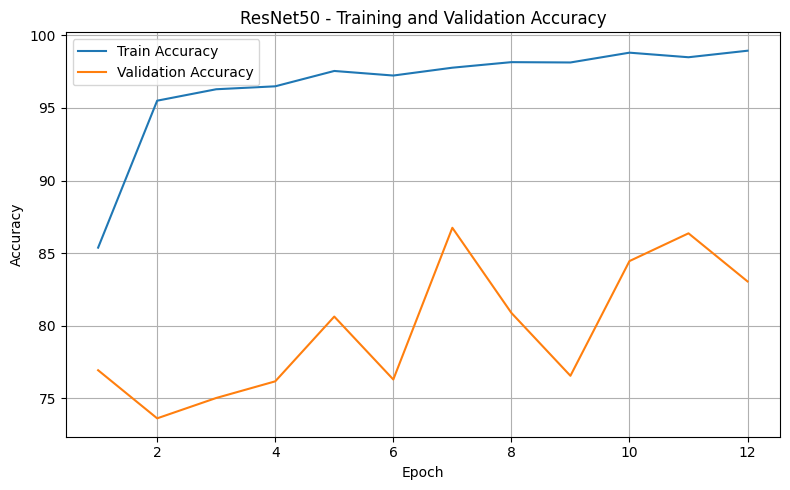

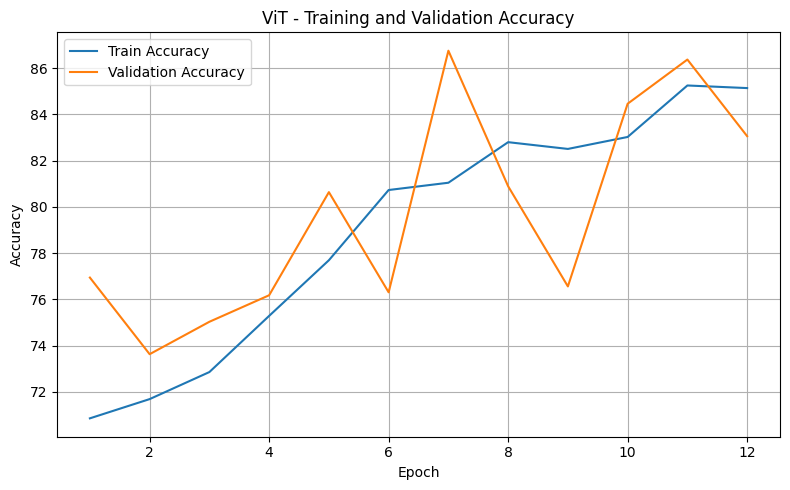

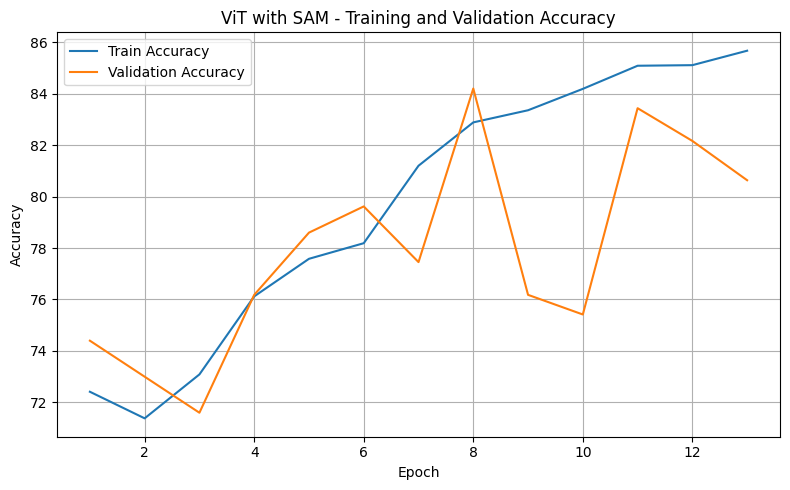

Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs


In [ ]:
plot_curves(history_resnet['train_accuracies'], history_vit['val_accuracies'], 'ResNet50', 'Accuracy')
plot_curves(history_vit['train_accuracies'], history_vit['val_accuracies'], 'ViT', 'Accuracy')
plot_curves(history_vit_sam['train_accuracies'], history_vit_sam['val_accuracies'], 'ViT with SAM', 'Accuracy')

backup_outputs()

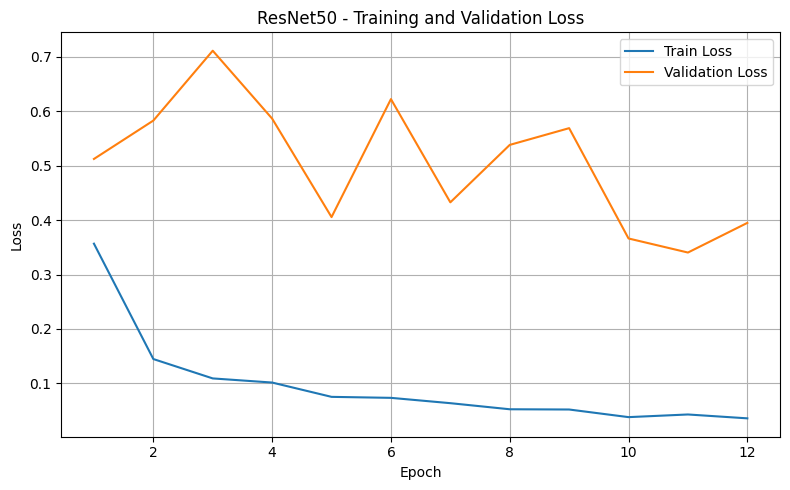

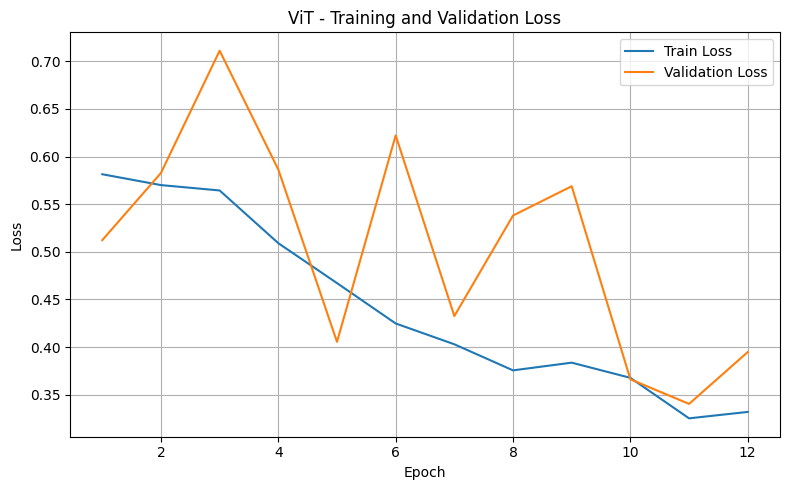

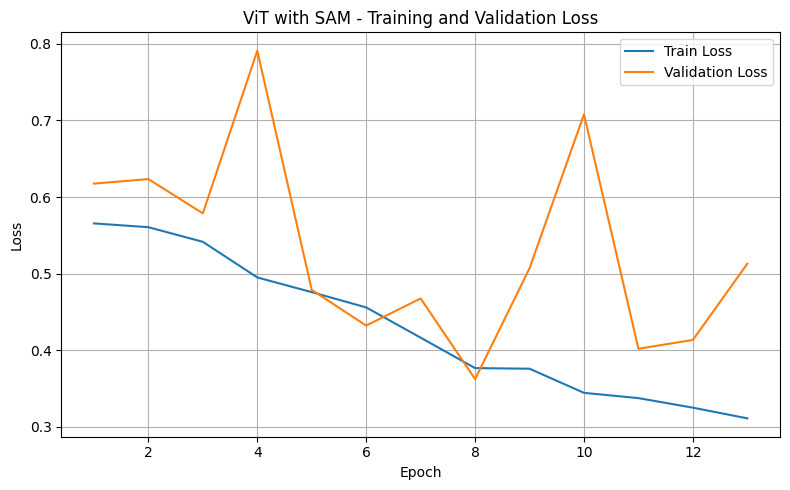

Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs


In [ ]:
plot_curves(history_resnet['train_losses'], history_vit['val_losses'], 'ResNet50', 'Loss')
plot_curves(history_vit['train_losses'], history_vit['val_losses'], 'ViT', 'Loss')
plot_curves(history_vit_sam['train_losses'], history_vit_sam['val_losses'], 'ViT with SAM', 'Loss')
backup_outputs()

## 9) Test Evaluation & models comparison

In [ ]:
def test_evaluation(model, ckpt_path, test_loader, device, save_path):
    all_preds = []
    all_labels = []
    all_probs = []
    test_correct = 0

    # state = torch.load(ckpt_path, map_location=device, weights_only=False)
    # model.load_state_dict(state['model'])
    model.load_state_dict(torch.load(ckpt_path))
    model.eval()

    with torch.no_grad():
        for X, y in tqdm(test_loader, desc='Test', leave=False):
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = outputs.argmax(1)

            #Accumulated results
            test_correct += (outputs.argmax(1) == y).sum().item()
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Metrics
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=["Normal", "Pneumonia"], output_dict=True)

    # Save classification report
    report_df = pd.DataFrame(report).transpose()
    report_df.to_csv(save_path, index=True)

    return {
        "all_probs": all_probs,
        "all_labels": all_labels,
        "all_preds": all_preds,
        "cm": cm,
        "report": report_df
    }


In [ ]:
test_resnet_f1 = test_evaluation(model_resnet, ckpt_path=os.path.join(cfg.output_dir,'models', "ResNet50_best_f1.pth"), test_loader=test_loader, device=device, save_path=os.path.join(cfg.output_dir, 'results',"ResNet50_classification_report_f1.csv"))
test_resnet_acc = test_evaluation(model_resnet, ckpt_path=os.path.join(cfg.output_dir,'models', "ResNet50_best_acc.pth"), test_loader=test_loader, device=device, save_path=os.path.join(cfg.output_dir, 'results',"ResNet50_classification_report_acc.csv"))

erase_file(model_dir, 'ResNet50_best_f1.pth')
erase_file(model_dir, 'ResNet50_best_acc.pth')


Fil deleted successfully.
Fil deleted successfully.


In [ ]:
test_vit_f1 = test_evaluation(model_vit, ckpt_path=os.path.join(cfg.output_dir,'models', "ViT_best_f1.pth"), test_loader=test_loader, device=device, save_path=os.path.join(cfg.output_dir, 'results',"ViT_classification_report_f1.csv"))
test_vit_acc = test_evaluation(model_vit, ckpt_path=os.path.join(cfg.output_dir,'models', "ViT_best_acc.pth"), test_loader=test_loader, device=device, save_path=os.path.join(cfg.output_dir, 'results',"ViT_classification_report_acc.csv"))

erase_file(model_dir, 'ViT_best_f1.pth')
erase_file(model_dir, 'ViT_best_acc.pth')

Fil deleted successfully.
Fil deleted successfully.


In [ ]:
test_vit_sam_f1 = test_evaluation(model_vit_sam, ckpt_path=os.path.join(cfg.output_dir,'models', "ViT_SAM_best_f1.pth"), test_loader=test_loader, device=device, save_path=os.path.join(cfg.output_dir, 'results',"ViT_SAM_classification_report_f1.csv"))
test_vit_sam_acc = test_evaluation(model_vit_sam, ckpt_path=os.path.join(cfg.output_dir,'models', "ViT_SAM_best_acc.pth"), test_loader=test_loader, device=device, save_path=os.path.join(cfg.output_dir, 'results',"ViT_SAM_classification_report_acc.csv"))

erase_file(model_dir, 'ViT_SAM_best_f1.pth')
erase_file(model_dir, 'ViT_SAM_best_acc.pth')

Fil deleted successfully.
Fil deleted successfully.


In [ ]:
frames = [
    test_resnet_f1['report'].assign(origin="ResNet_bestF1").reset_index(),
    test_vit_f1['report'].assign(origin="ViT_bestF1").reset_index(),
    test_vit_sam_f1['report'].assign(origin="VitSAM_bestF1").reset_index(),
]
combined_frames = pd.concat(frames, ignore_index=True)
combined_frames.to_csv(os.path.join(cfg.output_dir, 'results',"combined_classification_report_f1.csv"))

combined_frames

,index,precision,recall,f1-score,support,origin
0,Normal,0.982906,0.491453,0.655271,234.000000,ResNet_bestF1
1,Pneumonia,0.765286,0.994872,0.865106,390.000000,ResNet_bestF1
2,accuracy,0.806090,0.806090,0.806090,0.806090,ResNet_bestF1
3,macro avg,0.874096,0.743162,0.760188,624.000000,ResNet_bestF1
4,weighted avg,0.846893,0.806090,0.786418,624.000000,ResNet_bestF1
5,Normal,0.864865,0.410256,0.556522,234.000000,ViT_bestF1
6,Pneumonia,0.730994,0.961538,0.830565,390.000000,ViT_bestF1
7,accuracy,0.754808,0.754808,0.754808,0.754808,ViT_bestF1
8,macro avg,0.797930,0.685897,0.693543,624.000000,ViT_bestF1
9,weighted avg,0.781196,0.754808,0.727799,624.000000,ViT_bestF1


In [ ]:
frames = [
    test_resnet_acc['report'].assign(origin="ResNet_bestAcc").reset_index(),
    test_vit_acc['report'].assign(origin="ViT_bestAcc").reset_index(),
    test_vit_sam_acc['report'].assign(origin="VitSAM_bestAcc").reset_index(),
]
combined_frames = pd.concat(frames, ignore_index=True)
combined_frames.to_csv(os.path.join(cfg.output_dir, 'results',"combined_classification_report_acc.csv"))

combined_frames

,index,precision,recall,f1-score,support,origin
0,Normal,0.982906,0.491453,0.655271,234.000000,ResNet_bestAcc
1,Pneumonia,0.765286,0.994872,0.865106,390.000000,ResNet_bestAcc
2,accuracy,0.806090,0.806090,0.806090,0.806090,ResNet_bestAcc
3,macro avg,0.874096,0.743162,0.760188,624.000000,ResNet_bestAcc
4,weighted avg,0.846893,0.806090,0.786418,624.000000,ResNet_bestAcc
5,Normal,0.864865,0.410256,0.556522,234.000000,ViT_bestAcc
6,Pneumonia,0.730994,0.961538,0.830565,390.000000,ViT_bestAcc
7,accuracy,0.754808,0.754808,0.754808,0.754808,ViT_bestAcc
8,macro avg,0.797930,0.685897,0.693543,624.000000,ViT_bestAcc
9,weighted avg,0.781196,0.754808,0.727799,624.000000,ViT_bestAcc


In [ ]:
results_best_f1 = {
    "ResNet50": {"cm": test_resnet_f1["cm"],
                 "labels": test_resnet_f1["all_labels"],
                 "probs": test_resnet_f1["all_probs"]},
    "ViT":      {"cm": test_vit_f1["cm"],
                 "labels": test_vit_f1["all_labels"],
                 "probs": test_vit_f1["all_probs"]},
    "ViT_SAM": {"cm": test_vit_sam_f1["cm"],
                 "labels": test_vit_sam_f1["all_labels"],
                 "probs": test_vit_sam_f1["all_probs"]},
}

results_best_acc = {
    "ResNet50": {"cm": test_resnet_acc["cm"],
                 "labels": test_resnet_acc["all_labels"],
                 "probs": test_resnet_acc["all_probs"]},
    "ViT":      {"cm": test_vit_acc["cm"],
                 "labels": test_vit_acc["all_labels"],
                 "probs": test_vit_acc["all_probs"]},
    "ViT_SAM": {"cm": test_vit_sam_acc["cm"],
                 "labels": test_vit_sam_acc["all_labels"],
                 "probs": test_vit_sam_acc["all_probs"]},
}

In [ ]:
CLASSES = ["Normal", "Pneumonia"]
fig_dir = os.path.join(cfg.output_dir, 'figures')

# confusion matrix plot (normalized)
def plot_cm_row_norm_grid(results_dict, train_method, save_dir=fig_dir, classes=CLASSES, suptitle="Confusion Matrix (row-normalized)"):
    model_names = list(results_dict.keys())
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

    for ax, label in zip(axes, model_names):
        ax.set_title(label, fontsize=14, weight="bold", pad=22)

    for ax, m in zip(axes, model_names):
        cm = np.asarray(results_dict[m]["cm"], dtype=float)
        # Normalize rows (true-label rows)
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_norm = np.divide(cm, row_sums, out=np.zeros_like(cm), where=row_sums!=0)
        sns.heatmap(cm_norm, ax=ax, annot=True, fmt=".2f",
                    xticklabels=classes, yticklabels=classes, cbar=False,
                    vmin=0.0, vmax=1.0)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
    fig.suptitle(f"{train_method} - {suptitle}\n", fontsize=16, weight="bold")
    plt.savefig(os.path.join(save_dir, f'{train_method}_{suptitle}.png'), dpi=200)
    plt.show()

# ROC curve
def plot_roc_grid(results_dict, train_method, save_dir=fig_dir, suptitle="ROC Curves"):
    model_names =  list(results_dict.keys())
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)

    for ax, label in zip(axes, model_names):
        ax.set_title(label, fontsize=14, weight="bold", pad=22)

    for ax, m in zip(axes, model_names):
        y_true = np.asarray(results_dict[m]["labels"])
        y_prob = np.asarray(results_dict[m]["probs"], dtype=float)
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, linewidth=2, label=f"AUC={roc_auc:.3f}")
        ax.plot([0, 1], [0, 1], "--", linewidth=1)
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.legend(loc="lower right")
    fig.suptitle(f"{train_method} - {suptitle}\n", fontsize=16, weight="bold")
    plt.savefig(os.path.join(save_dir, f'{train_method}_{suptitle}.png'), dpi=200)
    plt.show()

# Precision-Recall curve
def plot_pr_grid(results_dict, train_method, save_dir=fig_dir, suptitle="Precision–Recall Curves"):
    model_names =  list(results_dict.keys())
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), constrained_layout=True)
    for ax, label in zip(axes, model_names):
        ax.set_title(label, fontsize=14, weight="bold", pad=22)
    for ax, m in zip(axes, model_names):
        y_true = np.asarray(results_dict[m]["labels"])
        y_prob = np.asarray(results_dict[m]["probs"], dtype=float)
        prec, rec, _ = precision_recall_curve(y_true, y_prob)
        ap = average_precision_score(y_true, y_prob)
        ax.plot(rec, prec, linewidth=2, label=f"AP={ap:.3f}")
        ax.set_xlabel("Recall")
        ax.set_ylabel("Precision")
        ax.legend(loc="lower left")
    fig.suptitle(f"{train_method} - {suptitle}\n", fontsize=16, weight="bold")
    plt.savefig(os.path.join(save_dir, f'{train_method}_{suptitle}.png'), dpi=200)
    plt.show()

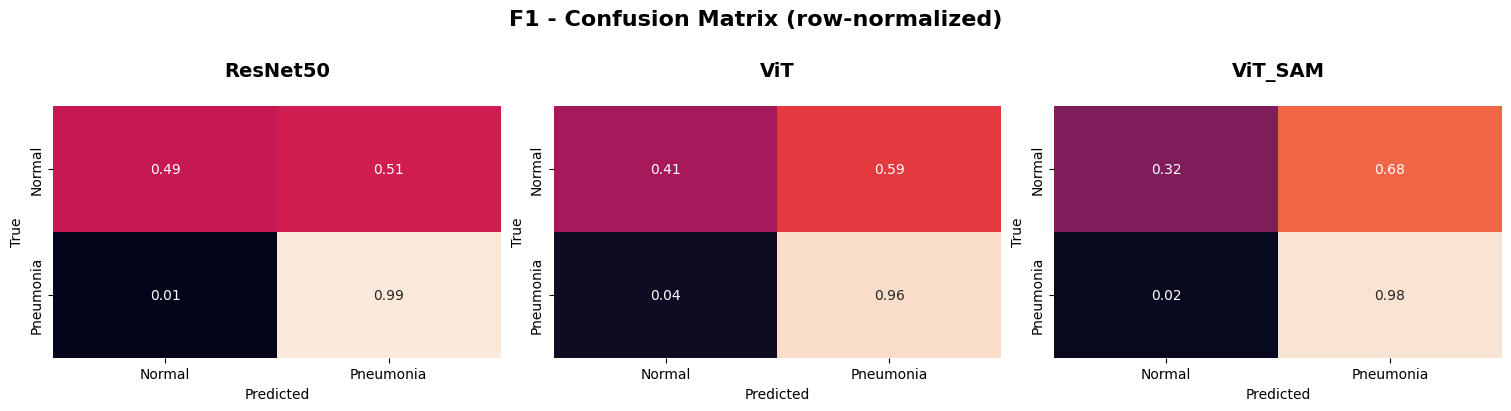

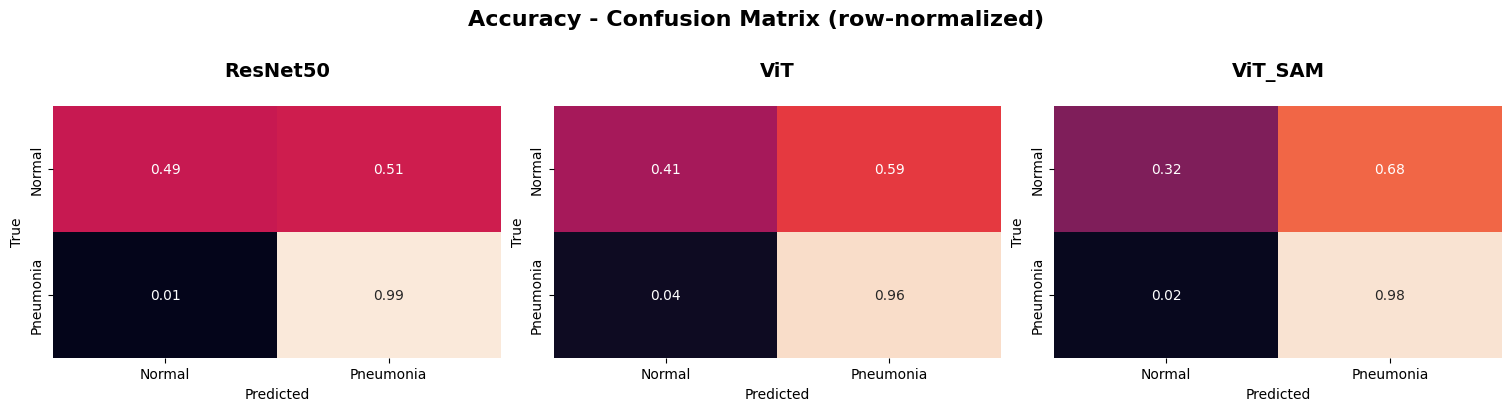

In [ ]:
plot_cm_row_norm_grid(results_best_f1, train_method = 'F1')
plot_cm_row_norm_grid(results_best_acc, train_method = 'Accuracy')

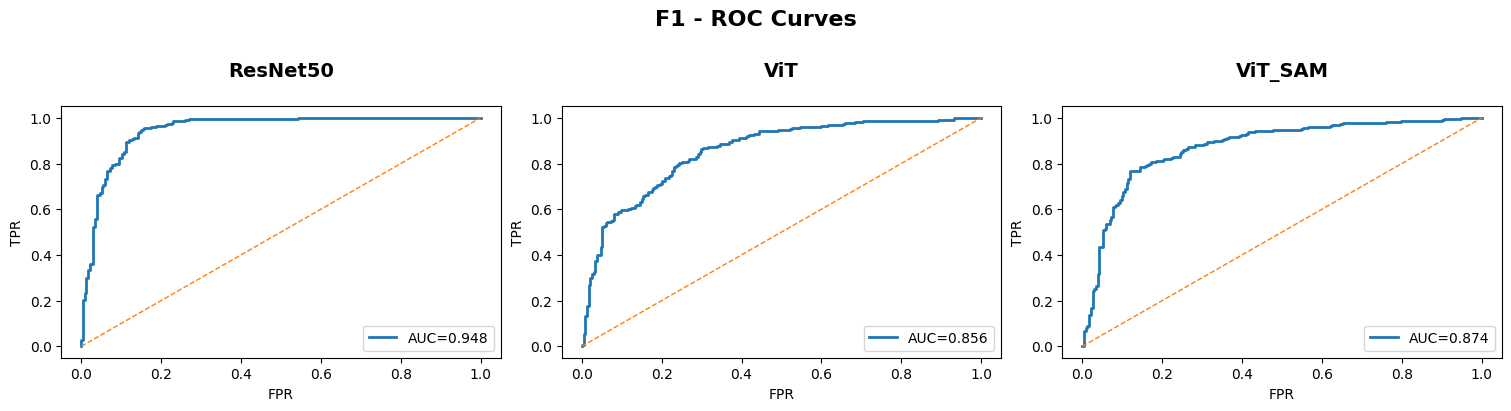

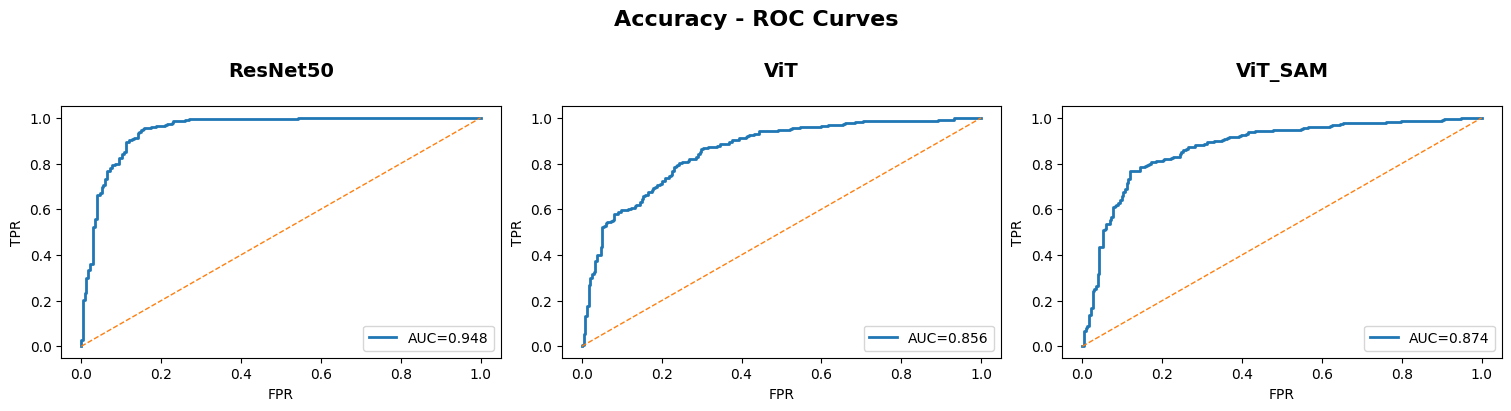

In [ ]:
plot_roc_grid(results_best_f1, train_method = 'F1')
plot_roc_grid(results_best_acc, train_method = 'Accuracy')

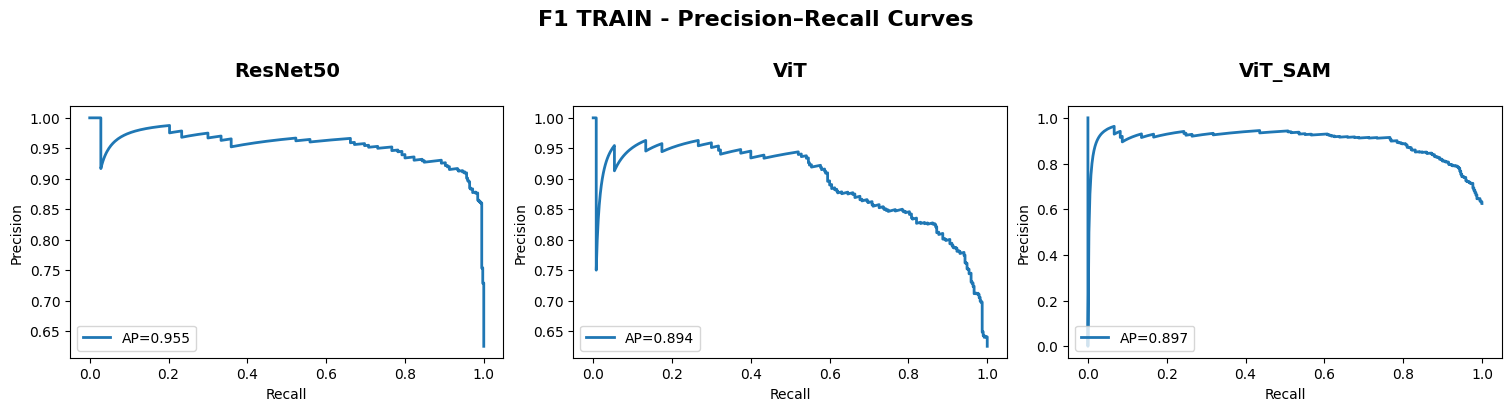

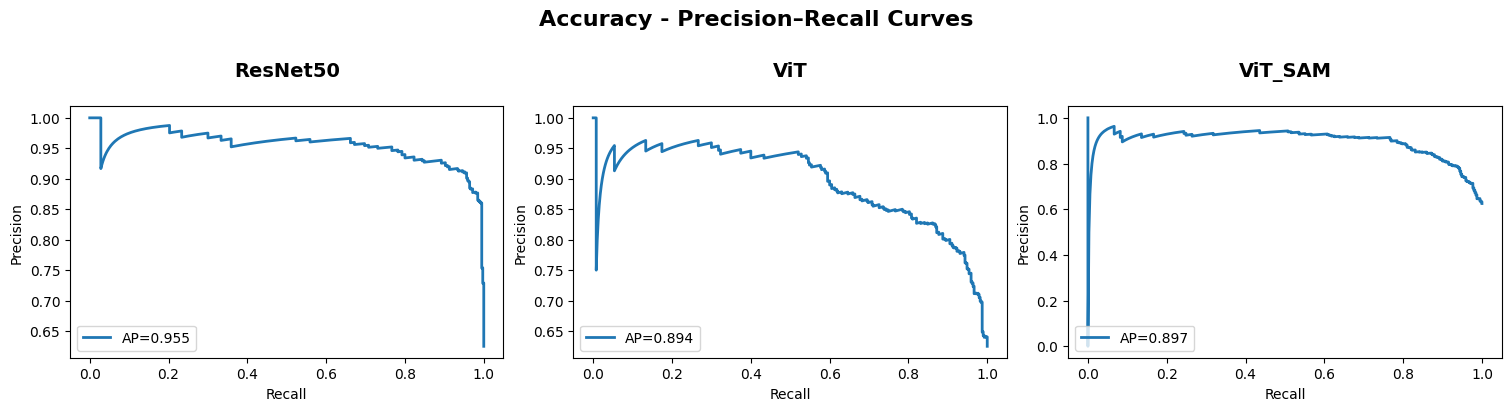

In [ ]:
plot_pr_grid(results_best_f1, train_method = 'F1 TRAIN')
plot_pr_grid(results_best_acc, train_method = 'Accuracy')

In [ ]:
backup_outputs()

Copied /content/Deep_Learning_Final_Project/outputs → /content/drive/MyDrive/project_backup/outputs
